In [75]:
import os
import numpy as np
import librosa
import soundfile as sf
import pandas as pd
import torch
import sys
import torchaudio.transforms as T


In [215]:


dis_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/trimmed_M16"
sani_mod_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/cleese_CM13"
sani_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/trimmed_CM13"
#excel_file = "C:/Users/gioel/Desktop/patient_GAN/patient_M14/risultati_FMA.xlsx"
out_dis_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/M16"
out_sano_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13"
out_sano_in_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13_in"
excel_file =  "C:/Users/gioel/Desktop/patient_GAN/patient_M16/report_durate_cleese.xlsx"
os.makedirs(out_dis_path, exist_ok=True)
os.makedirs(out_sano_path, exist_ok=True)
os.makedirs(out_sano_in_path, exist_ok=True)
df = pd.read_excel(excel_file)
file_names = df["FILE NAME"].astype(str).str.strip().tolist()




In [216]:
# === Parametri ===
target_sr = 22050
fade_ms = 20
fade_samples = int(target_sr * fade_ms / 1000)

In [217]:
# === Trova durata massima tra tutti i file ===
max_len = 0
for name in file_names:
    file_sano = os.path.join(sani_mod_path, f"{name}.wav")
    file_dis = os.path.join(dis_path, f"{name}.wav")
    file_sano_in = os.path.join(sani_path, f"{name}.wav")
    if not (os.path.exists(file_sano) and os.path.exists(file_dis)):
        continue

    sano, sr = librosa.load(file_sano, sr=target_sr)
    dis, _ = librosa.load(file_dis, sr=target_sr)
    sano_in, _ = librosa.load(file_sano_in, sr=target_sr)
    max_len = max(max_len, len(sano), len(dis), len(sano_in))

print(f"📏 Durata massima trovata: {max_len / target_sr:.3f} s")


📏 Durata massima trovata: 2.040 s


In [218]:
# Funzione per fade-out + padding
def fade_and_pad(wav, target_len):
    L = len(wav)
    if L > fade_samples:
        fade = np.linspace(1.0, 0.0, fade_samples)
        wav[-fade_samples:] *= fade
    pad_len = target_len - L
    if pad_len > 0:
        wav = np.pad(wav, (0, pad_len), mode="constant")
    return wav

In [219]:
for name in file_names:
    name = str(name).strip()
    file_sano = os.path.join(sani_mod_path, f"{name}.wav")
    file_sano_in = os.path.join(sani_path, f"{name}.wav")
    file_dis = os.path.join(dis_path, f"{name}.wav")

    if not (os.path.exists(file_sano) and os.path.exists(file_dis) and os.path.exists(file_sano_in) )  :
        print(f"❌ File mancante: {name}")
        continue

    # --- carica file ---
    sano, sr = librosa.load(file_sano, sr=target_sr)
    dis, sr = librosa.load(file_dis, sr=target_sr)
    sano_in, sr = librosa.load(file_sano_in, sr=target_sr)
    

    # --- padding smussato ---
    sano = fade_and_pad(sano, max_len)
    dis = fade_and_pad(dis, max_len)
    sano_in = fade_and_pad(sano_in, max_len)
    

    # --- normalizzazione coppia per coppia, ciascun file sul suo massimo ---
    eps = 1e-8  # per evitare divisione per zero
    sano_norm = sano / (np.max(np.abs(sano)) + eps)
    dis_norm  = dis  / (np.max(np.abs(dis)) + eps)
    sano_in_norm = sano_in / (np.max(np.abs(sano_in)) + eps)

    # --- salva ---
    sano_out = os.path.join(out_sano_path, f"{name}.wav")
    sano_in_out = os.path.join(out_sano_in_path, f"{name}.wav")
    dis_out = os.path.join(out_dis_path, f"{name}.wav")
    sf.write(sano_out, sano_norm, sr)
    sf.write(dis_out, dis_norm, sr)
    sf.write(sano_in_out, sano_in_norm, sr)

print("\n🎉 Tutti i file normalizzati e paddati salvati in:", f"{out_dis_path} e {out_sano_path} e {out_sano_in_path}")

filename = os.path.join(out_sano_path, "B1_UW16.wav")
y, sr = librosa.load(filename, sr=None)  # sr=None per non risamplare
duration = librosa.get_duration(y=y, sr=sr)
print(f"Durata: {duration:.2f} secondi", {sr})




🎉 Tutti i file normalizzati e paddati salvati in: C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/M16 e C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13 e C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13_in
Durata: 2.04 secondi {22050}


CREAZIONE SPETTROGRAMMI MEL_FBANK 80 DIMENSIONI

In [187]:
import torch

In [220]:
out_dis_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/M16"
out_sano_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13"
out_sano_in_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_data/CM13_in"
out_mel_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_spec_data"


# Crea lista dei file senza estensione
file_names = [f.split(".")[0] for f in os.listdir(out_sano_path) if f.endswith(".wav")]

os.makedirs(out_mel_path, exist_ok=True)

In [221]:

SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_MELS = 80
F_MIN = 0.0
F_MAX = 8000.0

In [222]:
# --- lista dei file sani normalizzati ---
sano_files = [f for f in os.listdir(out_sano_path) if f.endswith(".wav")]

def custom_mel_spectrogram(y, n_fft, n_mels, sample_rate, hop_length, win_length, f_min, f_max):
	mel_transform = T.MelSpectrogram(
		sample_rate=sample_rate,
		n_fft=n_fft,
		hop_length=hop_length,
		win_length=win_length,
		n_mels=n_mels,
		f_min=f_min,
		f_max=f_max,
		window_fn=torch.hann_window,
		center=False,
		pad_mode='reflect',
		power=1.0,
		norm='slaney',
		mel_scale='slaney'
	)

	mel_spec = mel_transform(y)  # [batch, n_mels, time]

	mel_spec = torch.log(torch.clamp(mel_spec, min=1e-5))

	return mel_spec


# # --- funzione per calcolare spettrogramma Mel ---
# def mel_tensor(y, sr):
#     mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
#                                             hop_length=hop_length, n_mels=n_mels, power = 2.0) #per gli spettri in potenza power = 2
#     mel_db = librosa.power_to_db(mel, ref=np.max) #se lo spettro è in potenza usare power_to_db
#     return torch.tensor(mel_db, dtype=torch.float32)

for sano_file in sano_files:
    # estrai il codice della parola
    name = sano_file.replace(".wav", "")
    dis_file = f"{name}.wav"

    sano_path = os.path.join(out_sano_path, sano_file)
    sano_in_path = os.path.join(out_sano_in_path, sano_file)
    dis_path = os.path.join(out_dis_path, dis_file)

    if not os.path.exists(dis_path):
        print(f"❌ File disartrico mancante: {dis_file}")
        continue

    # --- carica audio ---
    sano, sr = librosa.load(sano_path, sr=SAMPLE_RATE)
    sano_in, sr = librosa.load(sano_in_path, sr=SAMPLE_RATE)
    dis, sr = librosa.load(dis_path, sr=SAMPLE_RATE)

    sano = torch.tensor(sano, dtype=torch.float32).unsqueeze(0)
    sano_in = torch.tensor(sano_in, dtype=torch.float32).unsqueeze(0)
    dis = torch.tensor(dis, dtype=torch.float32).unsqueeze(0)    

    # tronca alla stessa lunghezza
    min_len = min(len(sano), len(dis), len(sano_in))
    sano = sano[:min_len]
    sano_in = sano_in[:min_len]
    dis = dis[:min_len]

    sano_mel = custom_mel_spectrogram(sano, n_fft=N_FFT, n_mels=N_MELS, sample_rate=SAMPLE_RATE, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, f_min=F_MIN, f_max=F_MAX)
    sano_in_mel = custom_mel_spectrogram(sano_in, n_fft=N_FFT, n_mels=N_MELS, sample_rate=SAMPLE_RATE, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, f_min=F_MIN, f_max=F_MAX)
    dis_mel = custom_mel_spectrogram(dis, n_fft=N_FFT, n_mels=N_MELS, sample_rate=SAMPLE_RATE, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, f_min=F_MIN, f_max=F_MAX)

    # --- crea sottocartella per la coppia ---
    out_dir = os.path.join(out_mel_path, name)
    os.makedirs(out_dir, exist_ok=True)

    # --- salva i tensor PyTorch ---
    torch.save(sano_mel, os.path.join(out_dir, "sano.pth"))
    torch.save(sano_in_mel, os.path.join(out_dir, "sano_in.pth"))
    torch.save(dis_mel, os.path.join(out_dir, "disartrico.pth"))



print("\n🎉 Tutti gli spettrogrammi Mel salvati in sottocartelle per coppia.")


🎉 Tutti gli spettrogrammi Mel salvati in sottocartelle per coppia.


NORMALIZZAZIONE SPETTROGRAMMI

In [206]:
from tqdm import tqdm

In [223]:
mel_src_path = "C:/Users/gioel/Desktop/patient_GAN/patient_M16/final_spec_data"
mel_out_path = "C:/Users/gioel/Desktop/patient_GAN_data/patient_M16/final_norm_spec_data"
os.makedirs(mel_out_path, exist_ok=True)

sano_list, sano_in_list, dis_list = [], [], []

In [224]:
for name in tqdm(os.listdir(mel_src_path)):
    pair_dir = os.path.join(mel_src_path, name)
    sano_path = os.path.join(pair_dir, "sano.pth")
    sano_in_path = os.path.join(pair_dir, "sano_in.pth")
    dis_path = os.path.join(pair_dir, "disartrico.pth")

    if not (os.path.exists(sano_path) and os.path.exists(dis_path) and os.path.exists(sano_in_path)):
        continue

    sano = torch.load(sano_path)
    sano_in = torch.load(sano_in_path)
    dis = torch.load(dis_path)
    sano_list.append(sano)
    sano_in_list.append(sano_in)
    dis_list.append(dis)

100%|██████████| 762/762 [00:41<00:00, 18.27it/s]


In [225]:
# concatena lungo l’asse temporale
sano_all = torch.cat(sano_list, dim=1)
sano_in_all = torch.cat(sano_in_list, dim=1)
dis_all = torch.cat(dis_list, dim=1)

# calcola media e std globali per ciascun dominio
mu_sano, sigma_sano = torch.mean(sano_all), torch.std(sano_all)
mu_sano_in, sigma_sano_in = torch.mean(sano_in_all), torch.std(sano_in_all)
mu_dis, sigma_dis = torch.mean(dis_all), torch.std(dis_all)

print(f"🩵 Sano -> mean: {mu_sano:.4f}, std: {sigma_sano:.4f}")
print(f"🩵 Sano IN -> mean: {mu_sano_in:.4f}, std: {sigma_sano_in:.4f}")
print(f"❤️ Disartrico -> mean: {mu_dis:.4f}, std: {sigma_dis:.4f}")

🩵 Sano -> mean: -9.2682, std: 3.5319
🩵 Sano IN -> mean: -9.7041, std: 3.2760
❤️ Disartrico -> mean: -9.3256, std: 3.4765


In [226]:
# Normalizza e salva per coppia 
print("\n🎧 Normalizzazione e salvataggio coppie...")
for name in tqdm(os.listdir(mel_src_path)):
    pair_dir = os.path.join(mel_src_path, name)
    sano_path = os.path.join(pair_dir, "sano.pth")
    sano_in_path = os.path.join(pair_dir, "sano_in.pth")
    dis_path = os.path.join(pair_dir, "disartrico.pth")

    if not (os.path.exists(sano_path) and os.path.exists(dis_path) and os.path.exists(sano_in_path)):
        print(f"⚠️  Mancano file in {name}, salto.")
        continue

    sano = torch.load(sano_path)
    sano_in = torch.load(sano_in_path)
    dis = torch.load(dis_path)

    # normalizza con statistiche globali del dominio
    sano_norm = (sano - mu_sano) / (sigma_sano + 1e-8)
    sano_in_norm = (sano_in - mu_sano_in) / (sigma_sano_in + 1e-8)
    dis_norm = (dis - mu_dis) / (sigma_dis + 1e-8)

    out_dir = os.path.join(mel_out_path, name)
    os.makedirs(out_dir, exist_ok=True)
    torch.save(sano_norm, os.path.join(out_dir, "sano.pth"))
    torch.save(sano_in_norm, os.path.join(out_dir, "sano_in.pth"))
    torch.save(dis_norm, os.path.join(out_dir, "disartrico.pth"))

print(f"\n✅ Tutti gli spettrogrammi normalizzati speaker-level salvati in: {mel_out_path}")


🎧 Normalizzazione e salvataggio coppie...


100%|██████████| 762/762 [00:05<00:00, 151.12it/s]


✅ Tutti gli spettrogrammi normalizzati speaker-level salvati in: C:/Users/gioel/Desktop/patient_GAN_data/patient_M16/final_norm_spec_data


VISIONE DEGLI SPETTROGRAMMI

In [212]:
import matplotlib.pyplot as plt

In [227]:
example_dir = "C:/Users/gioel/Desktop/patient_GAN_data/patient_M16/final_norm_spec_data/B1_UW18"
mel = torch.load("C:/Users/gioel/Desktop/patient_GAN_data/patient_M16/final_norm_spec_data/B1_UW18/sano.pth")  # cartella di una coppia esempio
sano_file = f"{example_dir}/sano.pth"
sano_in_file = f"{example_dir}/sano_in.pth"
dis_file = f"{example_dir}/disartrico.pth"
print(mel.shape)

torch.Size([1, 80, 172])


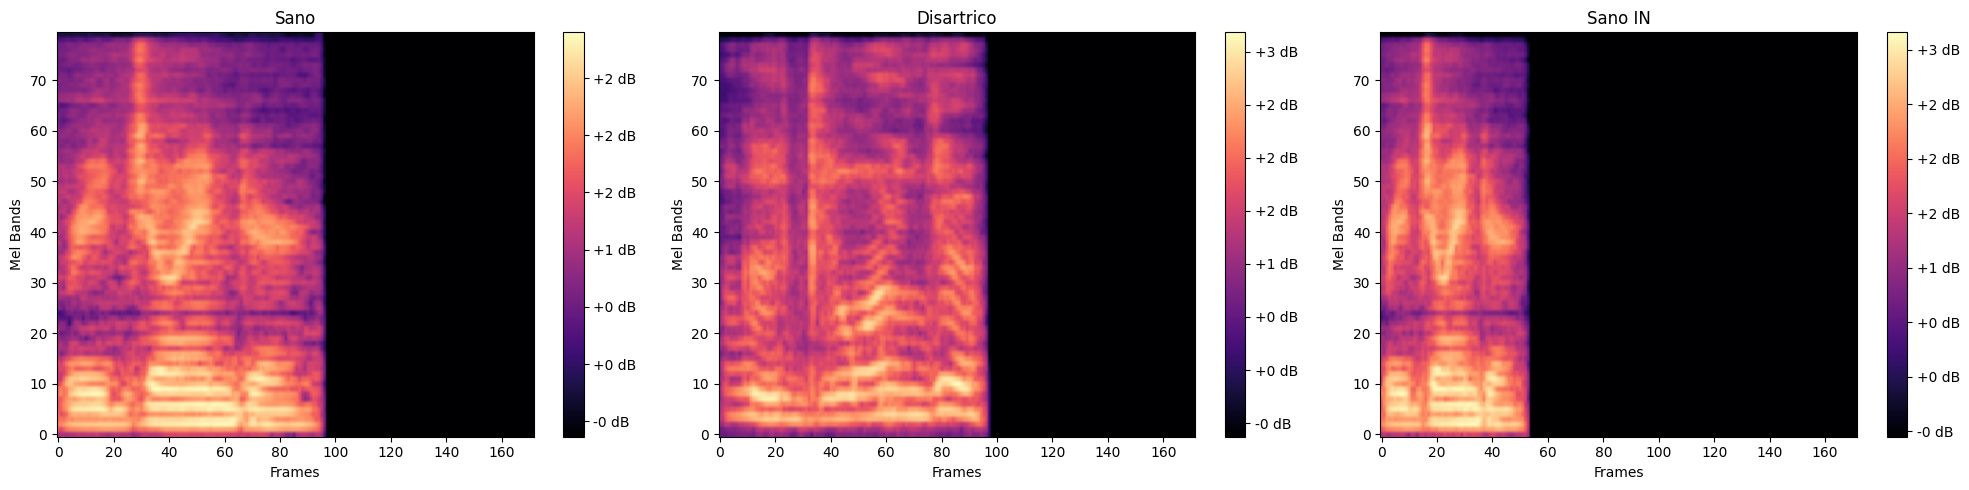

 frames = {frames}


In [228]:
sano_mel = torch.load(sano_file)
sano_in_mel = torch.load(sano_in_file)
dis_mel = torch.load(dis_file)

# --- visualizza ---
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(sano_mel.numpy().squeeze(0), origin="lower", aspect="auto", cmap="magma")
plt.title("Sano")
plt.xlabel("Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 2)
plt.imshow(dis_mel.numpy().squeeze(0), origin="lower", aspect="auto", cmap="magma")
plt.title("Disartrico")
plt.xlabel("Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 3, 3)
plt.imshow(sano_in_mel.numpy().squeeze(0), origin="lower", aspect="auto", cmap="magma")
plt.title("Sano IN")
plt.xlabel("Frames")
plt.ylabel("Mel Bands")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()
print(" frames = {frames}")

LEETURA DEI CSV PER CREAZIONE IMMAGINI


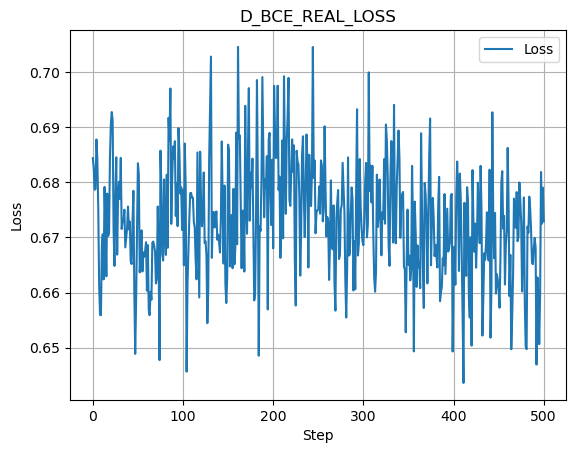

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggi il CSV
df = pd.read_csv(r"C:\Users\gioel\Desktop\run-.-tag-D_BCE_REAL_LOSS.csv")

# Plot
plt.plot(df["Step"], df["Value"], label="Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("D_BCE_REAL_LOSS")
plt.legend()
plt.grid(True)
plt.show()


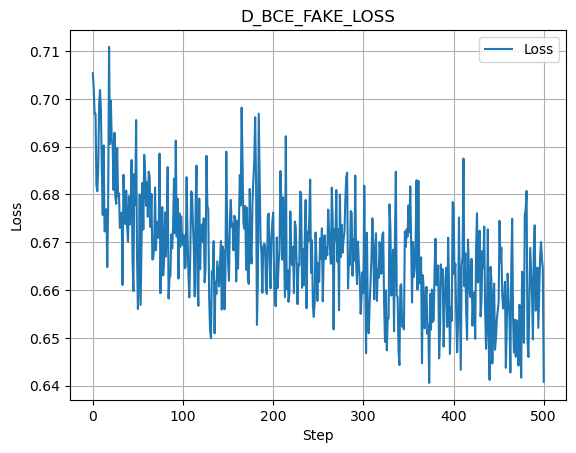

In [7]:


# Leggi il CSV
df = pd.read_csv(r"C:\Users\gioel\Desktop\run-.-tag-D_BCE_FAKE_LOSS.csv")

# Plot
plt.plot(df["Step"], df["Value"], label="Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("D_BCE_FAKE_LOSS")
plt.legend()
plt.grid(True)
plt.show()

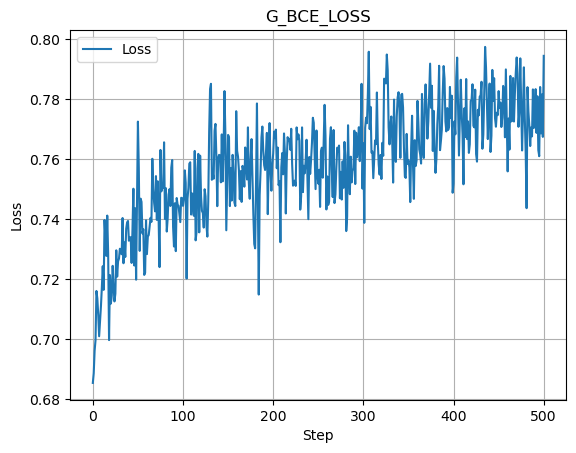

In [8]:


# Leggi il CSV
df = pd.read_csv(r"C:\Users\gioel\Desktop\run-.-tag-G_BCE_LOSS.csv")

# Plot
plt.plot(df["Step"], df["Value"], label="Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("G_BCE_LOSS")
plt.legend()
plt.grid(True)
plt.show()

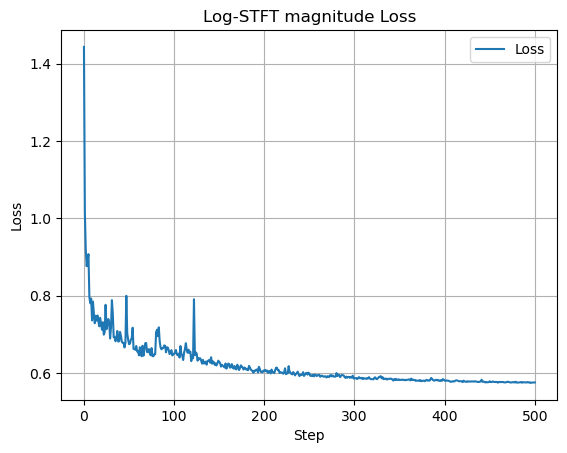

In [7]:


# Leggi il CSV
df = pd.read_csv(r"C:\Users\gioel\Desktop\generated_dis\spettrogrammi pth\curve_new\run-.-tag-G_MR_STFT_LOSS.csv")

# Plot
plt.plot(df["Step"], df["Value"], label="Loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Log-STFT magnitude Loss")
plt.legend()
plt.grid(True)
plt.show()

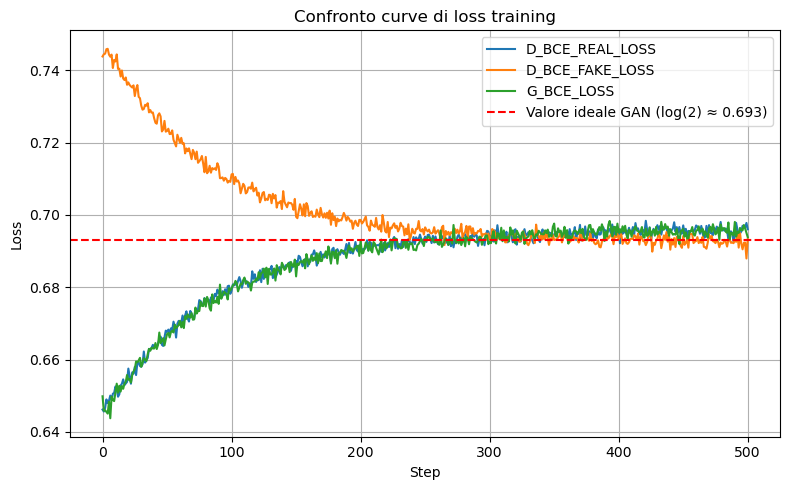

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggi i tre CSV
df1 = pd.read_csv(r"C:\Users\gioel\Desktop\generated_dis\spettrogrammi pth\curve_new\run-.-tag-D_BCE_REAL_LOSS.csv")
df2 = pd.read_csv(r"C:\Users\gioel\Desktop\generated_dis\spettrogrammi pth\curve_new\run-.-tag-D_BCE_FAKE_LOSS.csv")
df3 = pd.read_csv(r"C:\Users\gioel\Desktop\generated_dis\spettrogrammi pth\curve_new\run-.-tag-G_BCe_LOSS.csv")

plt.figure(figsize=(8,5))

plt.plot(df1["Step"], df1["Value"], label="D_BCE_REAL_LOSS")
plt.plot(df2["Step"], df2["Value"], label="D_BCE_FAKE_LOSS")
plt.plot(df3["Step"], df3["Value"], label="G_BCE_LOSS")

# Linea orizzontale al valore ideale
plt.axhline(y=0.693, color="red", linestyle="--", 
            label="Valore ideale GAN (log(2) ≈ 0.693)")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Confronto curve di loss training")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()